<a href="https://colab.research.google.com/github/seunghokimS/DACON-Temperature-prediction-/blob/main/%EA%B8%B0%EC%98%A8%EC%98%88%EC%B8%A1(EDA)%2C_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [ ]:
! pip install lightgbm

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from IPython.core.display import display, HTML
%matplotlib inline
import matplotlib.pylab as plt

plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'r'

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

Selecting previously unselected package fonts-nanum.
(Reading database ... 121658 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [ ]:
! pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import holidays
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter, YearLocator, MonthLocator
import matplotlib.dates as mdates
from matplotlib import container
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV
from pmdarima import auto_arima

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/공모전(Dacon)/기온예측/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/공모전(Dacon)/기온예측/sample_submission.csv')

In [ ]:
train.head()

,일시,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
0,1960-01-01,2.2,-5.2,7.4,NaN,68.3,1.7,6.7,NaN,NaN,-1.6
1,1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,NaN,NaN,-1.9
2,1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,NaN,NaN,4.0
3,1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,NaN,NaN,7.5
4,1960-01-05,1.3,-8.2,9.5,NaN,44.0,5.1,8.2,NaN,NaN,-4.6


# 데이터 정보

- 일사합
1. 일사합은 특정 기간 동안 지표면에 도달하는 태양 복사 에너지의 총량  
2. 메가줄(megajoules) 또는 킬로와트시(kilowatt-hours) 단위로 측정

- 일조율
1. 하루 중 태양이 빛나는 시간의 비율
2. 예를 들어, 하루가 10시간 길이이고, 그 중 5시간 동안 태양이 빛났다면, 일조율은 50%


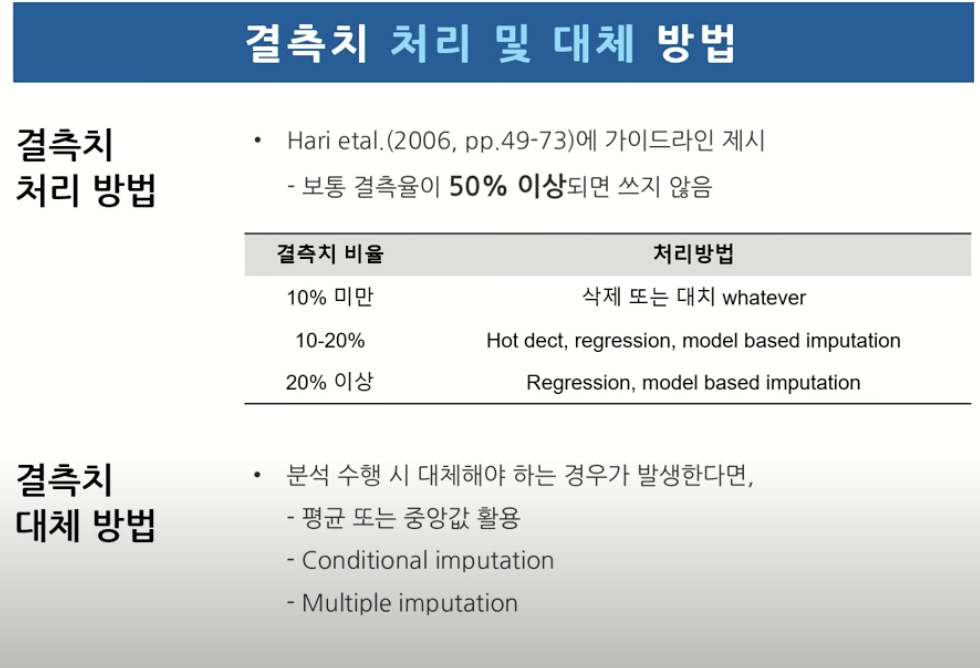

- hot dect : 작년 자료로 대체

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23011 entries, 0 to 23010
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      23011 non-null  object 
 1   최고기온    23008 non-null  float64
 2   최저기온    23008 non-null  float64
 3   일교차     23007 non-null  float64
 4   강수량     9150 non-null   float64
 5   평균습도    23011 non-null  float64
 6   평균풍속    23007 non-null  float64
 7   일조합     22893 non-null  float64
 8   일사합     18149 non-null  float64
 9   일조율     22645 non-null  float64
 10  평균기온    23011 non-null  float64
dtypes: float64(10), object(1)
memory usage: 1.9+ MB


In [ ]:
train.describe()

,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온
count,23008.000000,23008.000000,23007.000000,9150.000000,23011.000000,23007.000000,22893.000000,18149.000000,22645.000000,23011.000000
mean,17.071714,8.451960,8.619277,9.593683,65.202851,2.380993,5.858826,11.933170,48.653526,12.415419
std,10.714471,10.578285,2.907096,21.966135,14.549077,0.947595,3.816941,6.419122,31.662321,10.489515
min,-13.600000,-20.200000,1.000000,0.000000,17.900000,0.100000,0.000000,0.000000,0.000000,-16.400000
25%,7.800000,-0.300000,6.600000,0.100000,54.900000,1.700000,2.200000,7.000000,17.800000,3.400000
50%,18.900000,9.200000,8.600000,1.400000,65.500000,2.200000,6.600000,11.220000,55.700000,13.800000
75%,26.400000,17.900000,10.600000,8.500000,75.800000,2.900000,9.000000,16.620000,78.000000,21.800000
max,39.600000,30.300000,19.600000,332.800000,99.800000,7.800000,13.700000,33.480000,96.900000,33.700000


In [ ]:
(train.isnull().sum() / len(train)) * 100

일시       0.000000
최고기온     0.013037
최저기온     0.013037
일교차      0.017383
강수량     60.236409
평균습도     0.000000
평균풍속     0.017383
일조합      0.512798
일사합     21.129025
일조율      1.590544
평균기온     0.000000
dtype: float64

<ipython-input-14-118fe8fbe427>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = train.corr()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


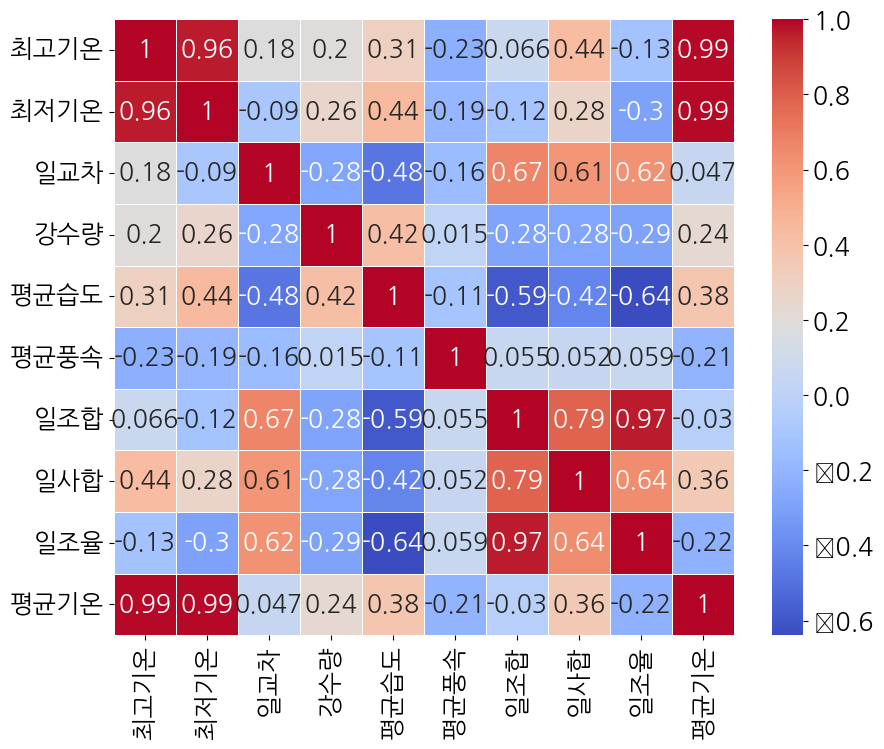

In [ ]:
corr_matrix = train.corr()

plt.figure(figsize = (10,8))
sns.heatmap(corr_matrix, annot = True, linewidths= .5 , cmap = 'coolwarm')
plt.show()

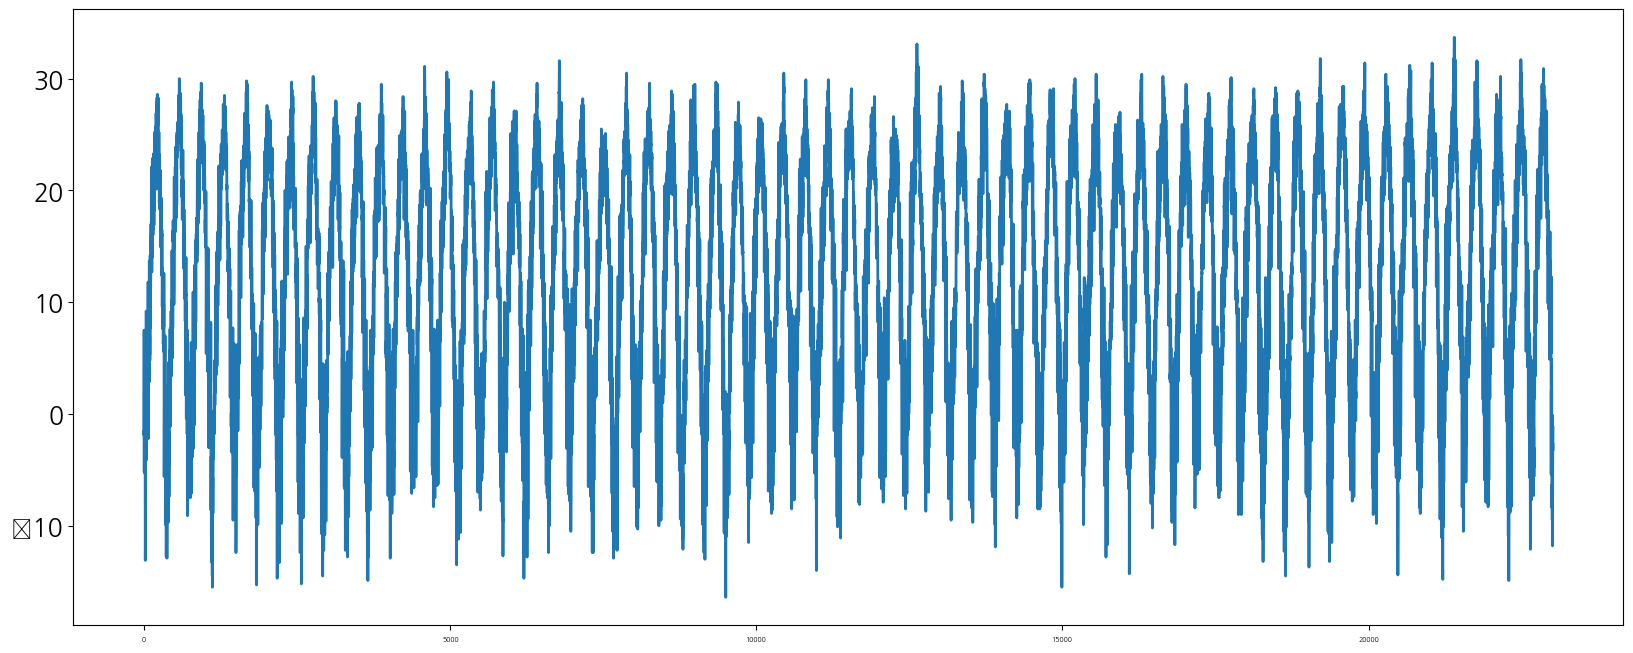

In [ ]:
# target값 그래프

plt.figure(figsize = (20,8))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(train.index)), train['평균기온'].to_numpy())
plt.show()

<ipython-input-16-aa83b78c763b>:13: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


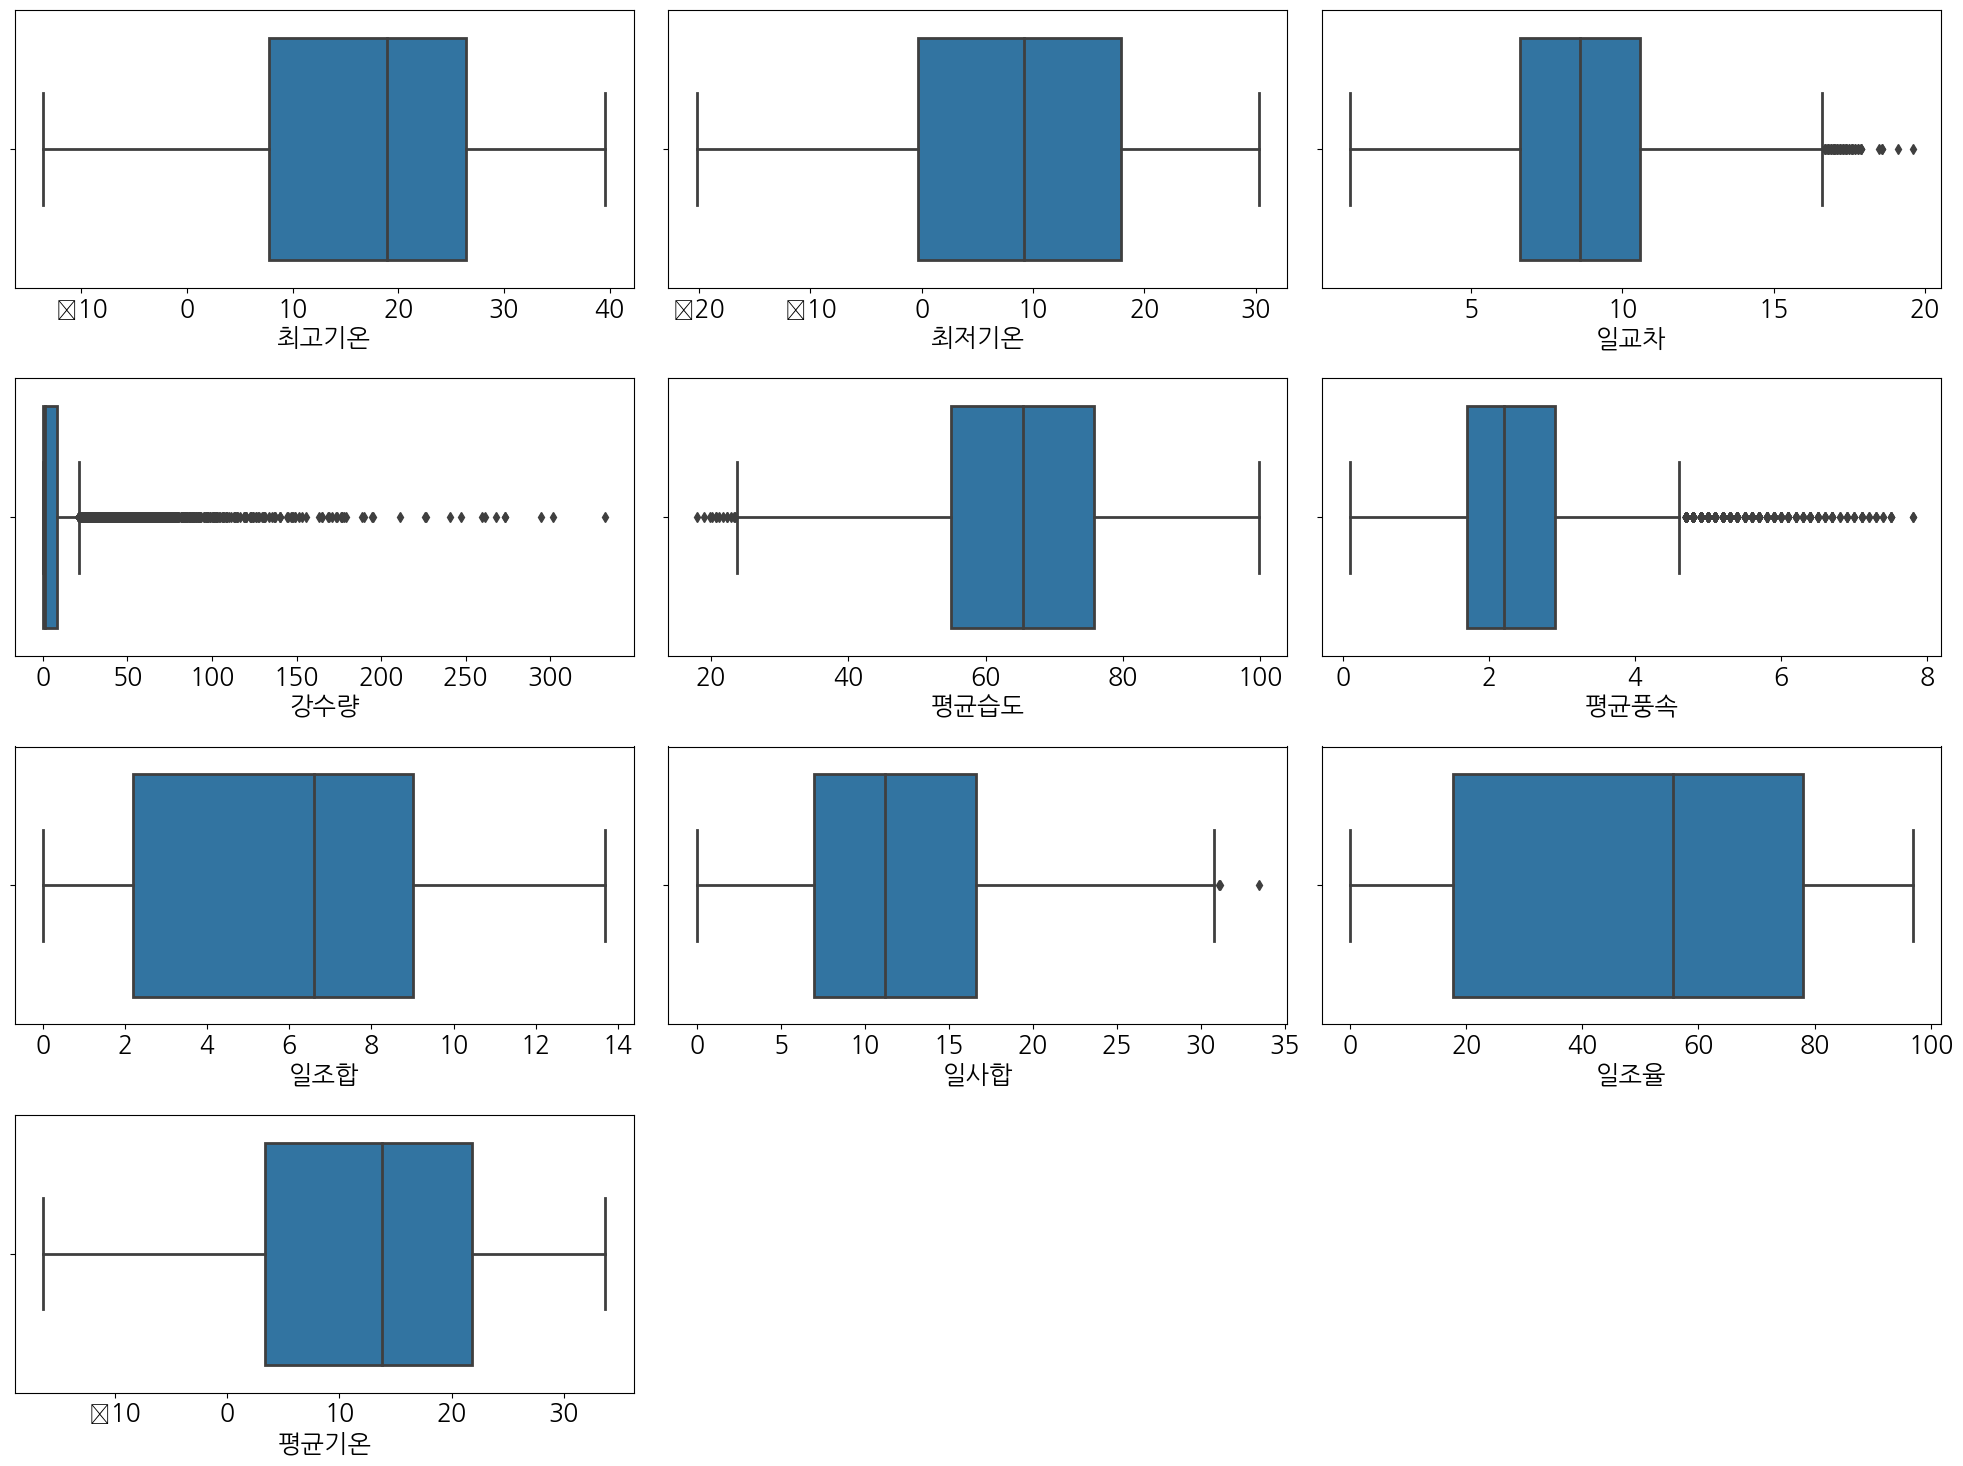

In [ ]:
num_cols = ['최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온']

fig , axes = plt.subplots(4,3, figsize=(20,15))

for i , col in enumerate(num_cols):
  row = i // 3
  col_idx = i % 3
  sns.boxplot(x = train[col], ax = axes[row , col_idx])

for i in range(len(num_cols), 12):
    axes[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


<ipython-input-17-38cb15fe9b7c>:14: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


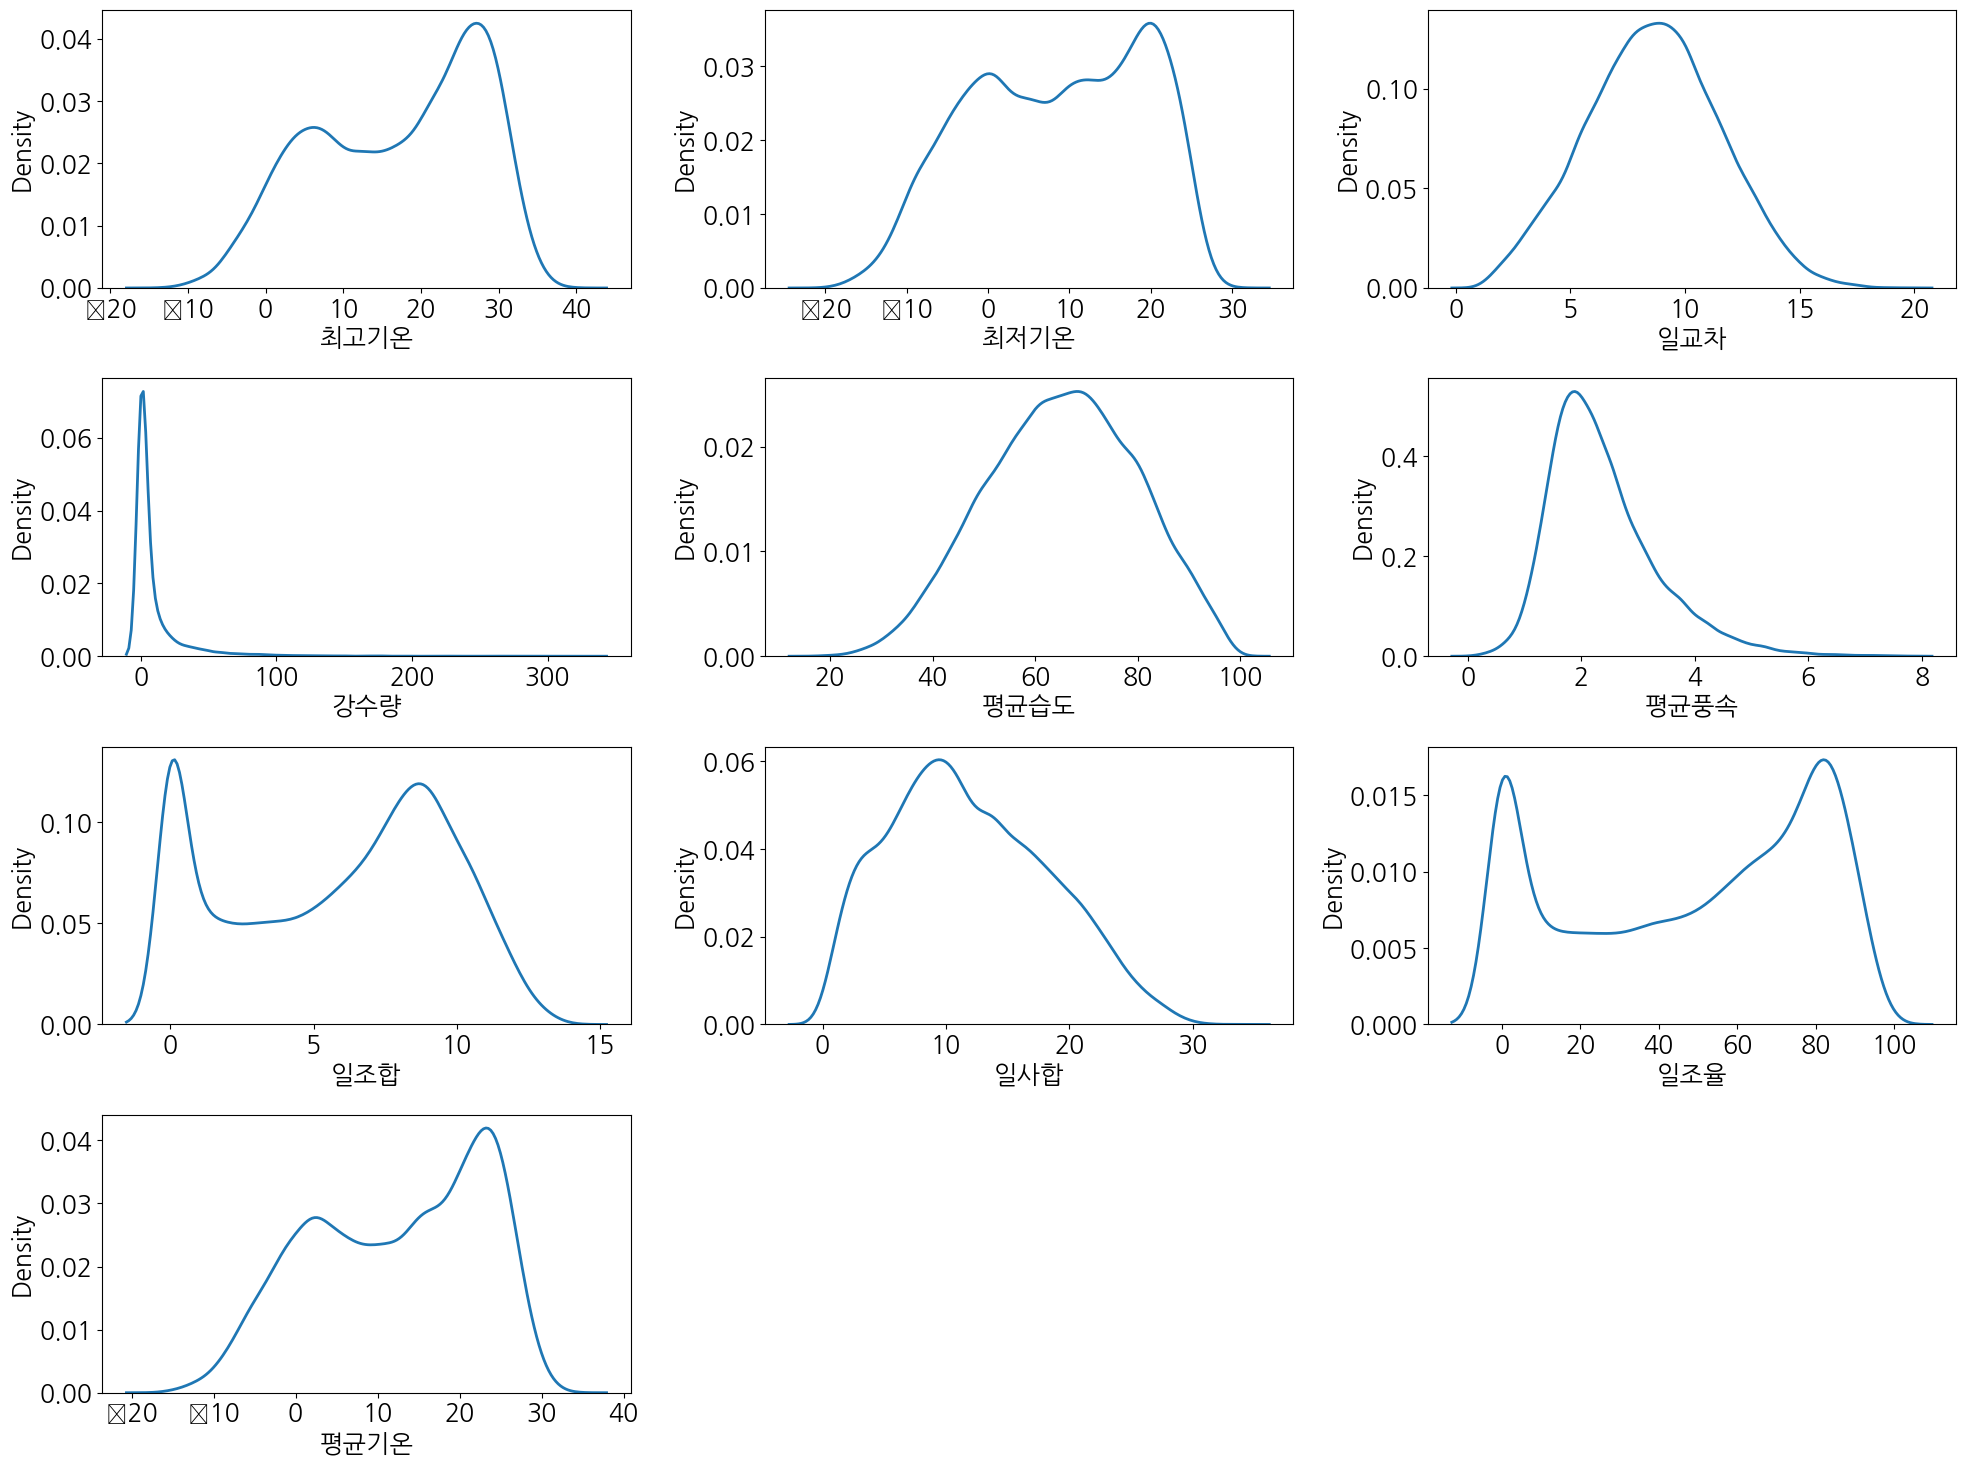

In [ ]:
num_cols = ['최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온']

fig , axes = plt.subplots(4,3, figsize=(20,15))

for i , col in enumerate(num_cols):
  row = i // 3
  col_idx = i % 3
  sns.kdeplot(x = train[col], ax = axes[row , col_idx])

for i in range(len(num_cols), 12):
    axes[i // 3, i % 3].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
train.columns

Index(['일시', '최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온'],
      dtype='object')

In [ ]:
df_na = (train.isnull().sum() / len(train)) * 100
df_na.sort_values(ascending=False)
df_na = df_na.drop(df_na[df_na==0].index).sort_values(ascending=False)
df_na

강수량     60.236409
일사합     21.129025
일조율      1.590544
일조합      0.512798
일교차      0.017383
평균풍속     0.017383
최고기온     0.013037
최저기온     0.013037
dtype: float64

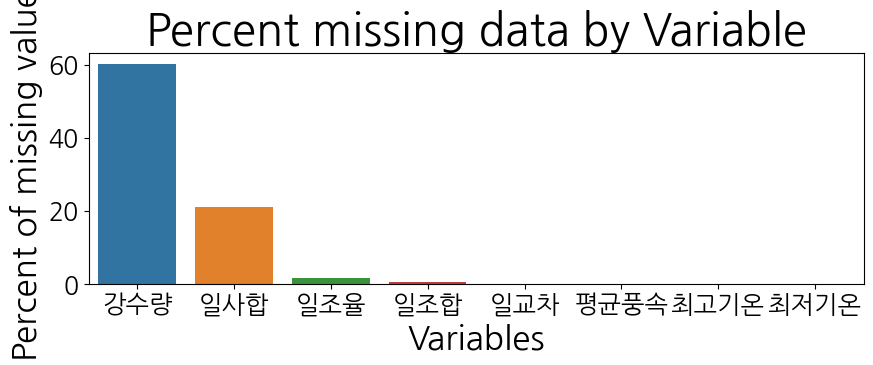

In [ ]:
f, ax = plt.subplots(figsize=(10, 3))
sns.barplot(x=df_na.index, y=df_na)
plt.xlabel('Variables', fontsize=24)
plt.ylabel('Percent of missing values', fontsize=24)
plt.title('Percent missing data by Variable', fontsize=32)
plt.show()

# 일사합 결측치 RF 전처리

In [ ]:
df_train = train.copy()

In [ ]:
df_train['일시'] = pd.to_datetime(df_train['일시'])
df_train['연'] = df_train['일시'].dt.year
df_train['월'] = df_train['일시'].dt.month
df_train['일'] = df_train['일시'].dt.day
df_train['강수량'] = df_train['강수량'].fillna(0)
cols_to_impute = ['최고기온','최저기온','일교차','평균풍속','일조율','일조합']
df_train[cols_to_impute] = df_train[cols_to_impute].fillna(method='bfill')

In [ ]:
df_train.drop(columns=['일시'], inplace=True)

In [ ]:
(df_train.isnull().sum() / len(train)) * 100

최고기온     0.000000
최저기온     0.000000
일교차      0.000000
강수량      0.000000
평균습도     0.000000
평균풍속     0.000000
일조합      0.000000
일사합     21.129025
일조율      0.000000
평균기온     0.000000
연        0.000000
월        0.000000
일        0.000000
dtype: float64

In [ ]:
train_value = df_train.dropna(subset=['일사합'])
train_missing = df_train[df_train['일사합'].isna()]

model = RandomForestRegressor()
model.fit(train_value.drop(columns=['일사합']), train_value['일사합'].astype('float64'))

predicted_values = model.predict(train_missing.drop(columns=['일사합']))
df_train.loc[df_train['일사합'].isna(), '일사합'] = predicted_values

In [ ]:
def train_and_evaluate(df):
    X = df_train.drop(columns=['평균기온'])
    y = df_train['평균기온']
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    models = {
        "RF": RandomForestRegressor(random_state=42),
        "XGB": XGBRegressor(random_state=42),
        "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
        "GB" : GradientBoostingRegressor(random_state=42),
        "AdaBoost" : AdaBoostRegressor(random_state=42),
        'lightgbm' : LGBMRegressor(random_state=42),
        'Ridge' : Ridge(random_state=42),
        'lasso' : Lasso(random_state=42),
        'ElasticNet' : ElasticNet(random_state=42),
        'SVR' : SVR()

    }

    best_score = float('inf')
    best_model = ""

    for name, model in models.items():
        model.fit(X_train, y_train)
        val_predictions = model.predict(X_val)
        val_mae = np.sqrt(mean_absolute_error(y_val, val_predictions))
        print(f"{name} val_data MAE: {val_mae}")
        if val_mae < best_score:
            best_score = val_mae
            best_model = name

    return best_model, best_score


results = []

best_model, best_score = train_and_evaluate(df_train)
results.append({'Best Model': best_model, 'Best mae': best_score})

results_df = pd.DataFrame(results)

print(results_df)

RF val_data MAE: 0.6192820999810515
XGB val_data MAE: 0.6150886247968789
CatBoost val_data MAE: 0.5995263835603941
GB val_data MAE: 0.6273535467777559
AdaBoost val_data MAE: 0.7827509349663672
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2015
[LightGBM] [Info] Number of data points in the train set: 18408, number of used features: 12
[LightGBM] [Info] Start training from score 12.382138
lightgbm val_data MAE: 0.6057587947845023
Ridge val_data MAE: 0.6220844833843917
lasso val_data MAE: 0.6349826931344659
ElasticNet val_data MAE: 0.631634445228129
SVR val_data MAE: 2.6474439107748875
  Best Model  Best mae
0   CatBoost  0.599526


# 일사합 catboost 처리

- 월 피처에 대해서만 푸리에 변환

In [ ]:
def preprocessing(df):
    df = df.copy()
    df['일시'] = pd.to_datetime(df['일시'])
    df['연'] = df['일시'].dt.year
    df['월'] = df['일시'].dt.month
    df['월_cos'] = np.cos(2 * np.pi * df['월'] / 12)
    df['월_sin'] = np.sin(2 * np.pi * df['월'] / 12)
    df['기온이동평균(7일)'] = df['평균기온'].rolling(window=7, min_periods=1).mean()
    df['기온이동평균(30일)'] = df['평균기온'].rolling(window=30, min_periods=1).mean()
    df['기온이동평균(90일)'] = df['평균기온'].rolling(window=90, min_periods=1).mean()
    df['강수량'] = df['강수량'].fillna(0)
    cols_to_impute = ['최고기온', '최저기온', '일교차', '평균풍속', '일조율', '일조합']
    df[cols_to_impute] = df[cols_to_impute].fillna(method='bfill')
    df.drop(columns=['월'], inplace=True)
    df.set_index('일시', inplace=True)

    param_grid = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'iterations': [30, 50, 100, 200]
    }

    train_value = df.dropna(subset=['일사합'])
    train_missing = df[df['일사합'].isna()]

    model = CatBoostRegressor(verbose=0)
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(train_value.drop(columns=['일사합']), train_value['일사합'].astype('float64'))

    best_params = grid_search.best_params_
    print("Best parameters:", grid_search.best_params_)
    print("Best score:", grid_search.best_score_)
    model = CatBoostRegressor(**best_params, verbose=0)
    model.fit(train_value.drop(columns=['일사합']), train_value['일사합'].astype('float64'))

    # 예측 및 결측치 채우기
    predicted_values = model.predict(train_missing.drop(columns=['일사합']))
    df.loc[df['일사합'].isna(), '일사합'] = predicted_values

    return df

df = preprocessing(train)
df

Best parameters: {'depth': 10, 'iterations': 100, 'learning_rate': 0.05}
Best score: -1.720905528482655


,최고기온,최저기온,일교차,강수량,평균습도,평균풍속,일조합,일사합,일조율,평균기온,연,월_cos,월_sin,기온이동평균(7일),기온이동평균(30일),기온이동평균(90일)
일시,,,,,,,,,,,,,,,,
1960-01-01,2.2,-5.2,7.4,0.0,68.3,1.7,6.7,8.194105,28.1,-1.6,1960,0.866025,5.000000e-01,-1.600000,-1.600000,-1.600000
1960-01-02,1.2,-5.6,6.8,0.4,87.7,1.3,0.0,5.098014,28.1,-1.9,1960,0.866025,5.000000e-01,-1.750000,-1.750000,-1.750000
1960-01-03,8.7,-2.1,10.8,0.0,81.3,3.0,0.0,5.407577,28.1,4.0,1960,0.866025,5.000000e-01,0.166667,0.166667,0.166667
1960-01-04,10.8,1.2,9.6,0.0,79.7,4.4,2.6,6.289536,28.1,7.5,1960,0.866025,5.000000e-01,2.000000,2.000000,2.000000
1960-01-05,1.3,-8.2,9.5,0.0,44.0,5.1,8.2,9.988231,28.1,-4.6,1960,0.866025,5.000000e-01,0.680000,0.680000,0.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3.3,-7.3,10.6,0.0,69.8,1.8,8.8,10.250000,91.7,-2.6,2022,1.000000,-2.449294e-16,-5.714286,-2.143333,7.948889
2022-12-28,0.1,-6.0,6.1,0.1,58.1,2.5,8.7,10.860000,90.6,-3.3,2022,1.000000,-2.449294e-16,-6.171429,-2.663333,7.685556
2022-12-29,2.1,-7.8,9.9,0.0,56.3,1.7,9.0,10.880000,93.8,-2.9,2022,1.000000,-2.449294e-16,-5.471429,-2.990000,7.423333


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


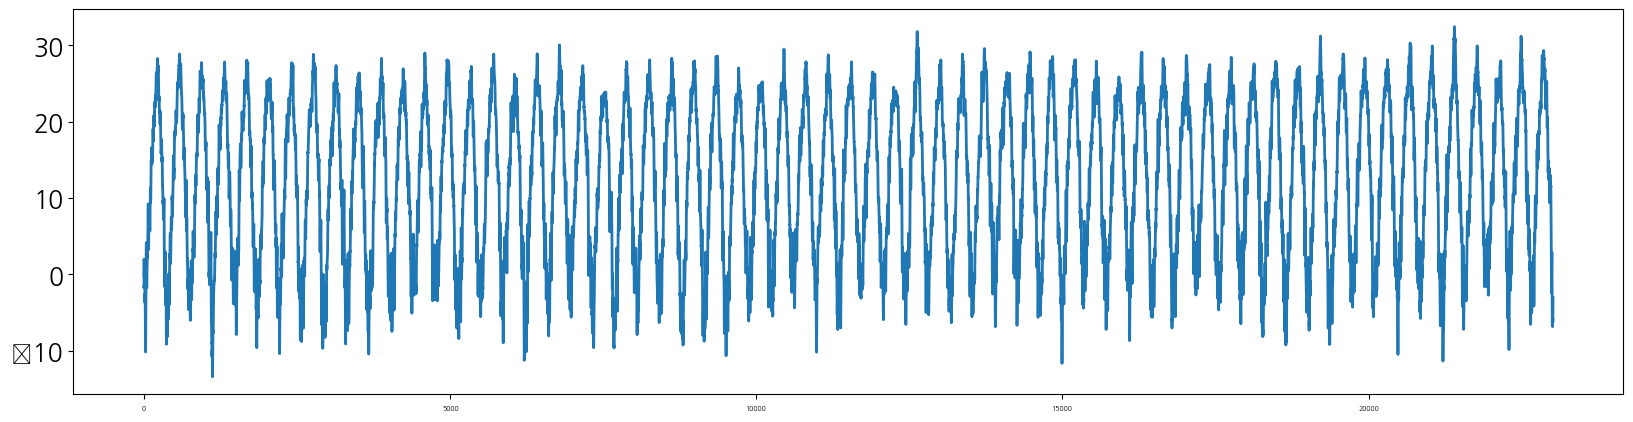

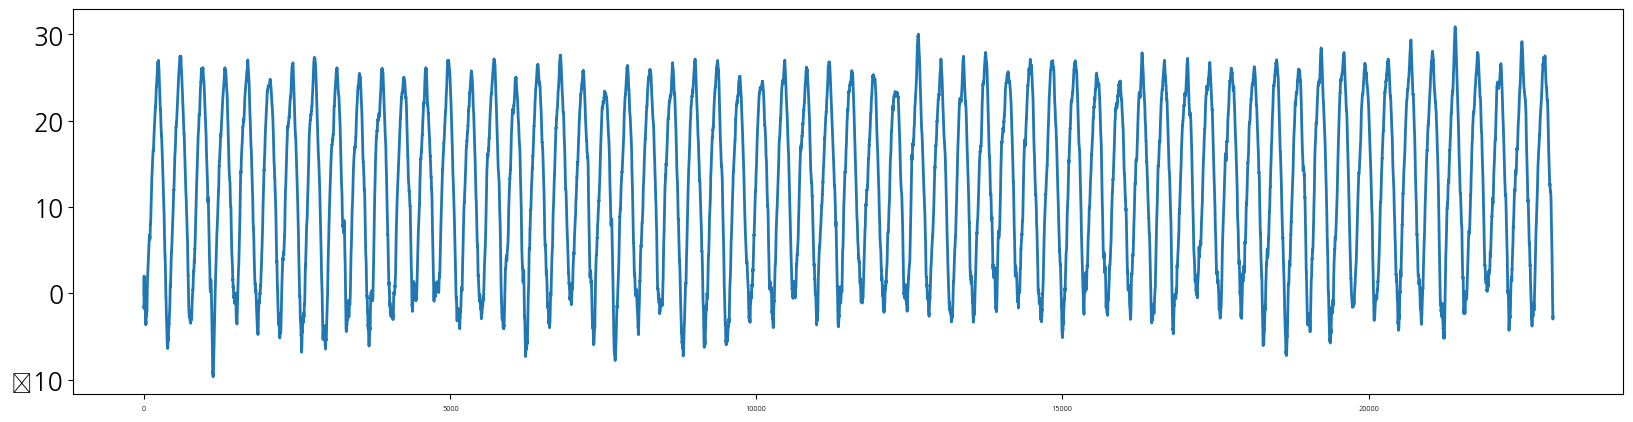

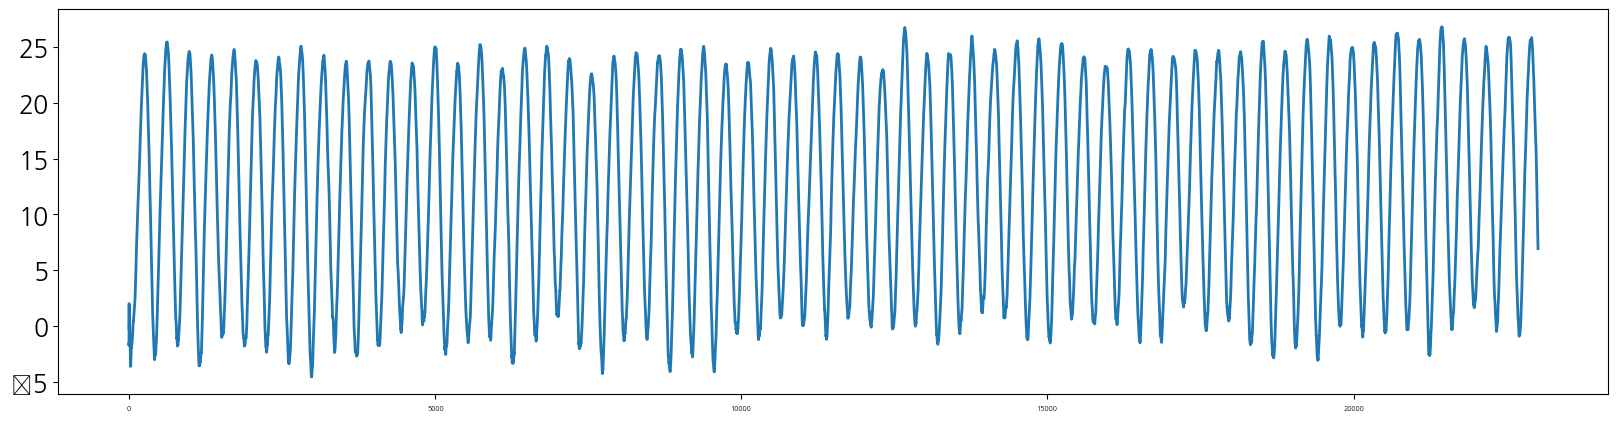

In [ ]:
plt.figure(figsize = (20,5))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(train.index)), df['기온이동평균(7일)'].to_numpy())

plt.figure(figsize = (20,5))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(train.index)), df['기온이동평균(30일)'].to_numpy())

plt.figure(figsize = (20,5))
plt.xticks(fontsize=5)
plt.plot(np.arange(len(train.index)), df['기온이동평균(90일)'].to_numpy())
plt.show()

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


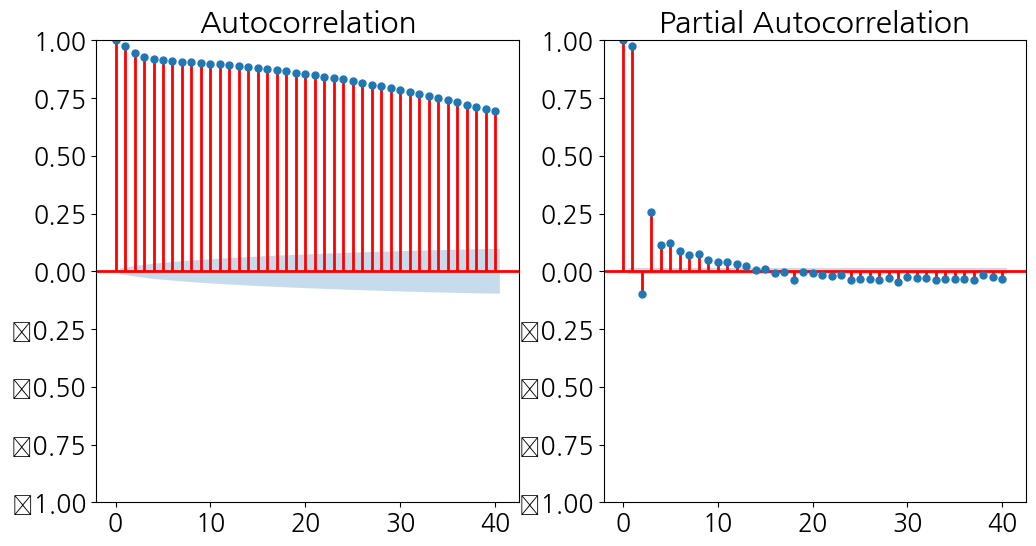

In [ ]:
temp_df = df['평균기온']

plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(temp_df, ax=plt.gca(), lags=40)

plt.subplot(122)
plot_pacf(temp_df, ax=plt.gca(), lags=40)

plt.show()

# 정상성 검정
 - 정상성은 데이터의 평균과 분산이 안정되어있는 상태
 - 평균과 분산이 일정하지 않은면 차분(평균일정 X) , 및 변환(분산 일정X)


In [ ]:
df_col = df.columns
df_col

Index(['최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온', '연', '월_cos', '월_sin', '기온이동평균(7일)', '기온이동평균(30일)',
       '기온이동평균(90일)'],
      dtype='object')

In [ ]:
# 정상성(stationary)

adf_test_list = []

for i in df_col:
  adf_test = adfuller(df[i], autolag = "AIC")
  adf_test_list.append([i, adf_test[0], adf_test[1]])

df_stationary = pd.DataFrame(adf_test_list, columns=['col_name','ADF_statistic','p-value'])
df_stationary

,col_name,ADF_statistic,p-value
0,최고기온,-15.752685,1.217975e-28
1,최저기온,-16.434286,2.461766e-29
2,일교차,-18.183772,2.429195e-30
3,강수량,-18.820381,2.022204e-30
4,평균습도,-13.237916,9.297273e-25
5,평균풍속,-12.013116,3.147153e-22
6,일조합,-19.713249,0.000000e+00
7,일사합,-12.110045,1.928738e-22
8,일조율,-14.580433,4.477673e-27
9,평균기온,-16.619186,1.704000e-29


In [ ]:
df.columns

Index(['최고기온', '최저기온', '일교차', '강수량', '평균습도', '평균풍속', '일조합', '일사합', '일조율',
       '평균기온', '연', '월_cos', '월_sin', '기온이동평균(7일)', '기온이동평균(30일)',
       '기온이동평균(90일)'],
      dtype='object')

In [ ]:
def preprocessing(df):
    df = df.copy()
    df['일시'] = pd.to_datetime(df['일시'])
    df['연'] = df['일시'].dt.year
    df['월'] = df['일시'].dt.month
    df['월_cos'] = np.cos(2 * np.pi * df['월'] / 12)
    df['월_sin'] = np.sin(2 * np.pi * df['월'] / 12)
    df.drop(columns=['월'], inplace=True)
    df.set_index('일시', inplace=True)
    df = df[['평균기온','연','월_cos', '월_sin']]
    return df

df = preprocessing(train)
df

,평균기온,연,월_cos,월_sin
일시,,,,
1960-01-01,-1.6,1960,0.866025,5.000000e-01
1960-01-02,-1.9,1960,0.866025,5.000000e-01
1960-01-03,4.0,1960,0.866025,5.000000e-01
1960-01-04,7.5,1960,0.866025,5.000000e-01
1960-01-05,-4.6,1960,0.866025,5.000000e-01
...,...,...,...,...
2022-12-27,-2.6,2022,1.000000,-2.449294e-16
2022-12-28,-3.3,2022,1.000000,-2.449294e-16
2022-12-29,-2.9,2022,1.000000,-2.449294e-16


In [ ]:
sub = preprocessing(submission)
sub

,평균기온,연,월_cos,월_sin
일시,,,,
2023-01-01,0,2023,0.866025,5.000000e-01
2023-01-02,0,2023,0.866025,5.000000e-01
2023-01-03,0,2023,0.866025,5.000000e-01
2023-01-04,0,2023,0.866025,5.000000e-01
2023-01-05,0,2023,0.866025,5.000000e-01
...,...,...,...,...
2023-12-20,0,2023,1.000000,-2.449294e-16
2023-12-21,0,2023,1.000000,-2.449294e-16
2023-12-22,0,2023,1.000000,-2.449294e-16


# sarimax(데이터분할)


In [ ]:
df_trian = df[:-358]
df_test = df[-358:]

In [ ]:
model = auto_arima(df['평균기온'],
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   d=1, D=1,
                   max_order=None,
                   trace=True,
                   error_action='ignore',  # 에러 발생 시 무시
                   seasonal=True,  # 계절성 주기 m 설정
                   stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=104328.023, Time=11.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=105052.236, Time=0.65 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=104897.100, Time=1.71 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104747.577, Time=3.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=105050.236, Time=0.37 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=101906.995, Time=12.70 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=103178.596, Time=3.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=101855.342, Time=22.46 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=102845.972, Time=4.79 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=101830.449, Time=24.71 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=101836.884, Time=18.68 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=101616.081, Time=87.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=101355.187, Time=68.39 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=101852.884, Time=17.52 s

In [ ]:
model.get_params()['seasonal_order'][3]

0

In [ ]:
y = df['평균기온']  # 예측하고자 하는 타겟 변수
exog = df[['연', '월_cos', '월_sin']]  # 외생 변수


y_train, y_val = y[:-358], y[-358:]
exog_train, exog_val = exog[:-358], exog[-358:]


model = SARIMAX(y_train, exog=exog_train, order=(2, 1, 3), seasonal_order=(0, 0, 0, 0))
results = model.fit()

# 검증 데이터에 대한 예측 수행
forecast_val = results.get_forecast(steps=len(y_val), exog=exog_val)

# 예측 결과
predictions_val = forecast_val.predicted_mean

# 예측 결과와 실제 값 비교 (예: MSE 계산)
mae = mean_absolute_error(y_val, predictions_val)
print(f'Validation MAE: {mae}')

# 예측 데이터셋 준비 (외생 변수)
exog_future = sub[['연', '월_cos', '월_sin']]

# 예측 데이터셋에 대한 예측 수행
forecast_future = results.get_forecast(steps=len(sub), exog=exog_future)

# 미래 예측 결과
predictions_future = forecast_future.predicted_mean

# 미래 예측 결과 출력
print(predictions_future)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Validation MSE: 24.469989658043563
2022-01-08    -1.517860
2022-01-09    -2.278681
2022-01-10    -2.769830
2022-01-11    -3.111835
2022-01-12    -3.370808
                ...    
2022-12-27   -12.215112
2022-12-28   -12.215493
2022-12-29   -12.215868
2022-12-30   -12.216236
2022-12-31   -12.216598
Freq: D, Name: predicted_mean, Length: 358, dtype: float64


In [ ]:
# def train_and_evaluate(df):
#     X = df.drop(columns=['평균기온'])
#     y = df['평균기온']
#     X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#     models = {
#         "RF": RandomForestRegressor(random_state=42),
#         "XGB": XGBRegressor(random_state=42),
#         "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
#         "GB" : GradientBoostingRegressor(random_state=42),
#         "AdaBoost" : AdaBoostRegressor(random_state=42),
#         'lightgbm' : LGBMRegressor(random_state=42),
#         'Ridge' : Ridge(random_state=42),
#         'lasso' : Lasso(random_state=42),
#         'ElasticNet' : ElasticNet(random_state=42),
#         'SVR' : SVR()

#     }

#     best_score = float('inf')
#     best_model = ""

#     for name, model in models.items():
#         model.fit(X_train, y_train)
#         val_predictions = model.predict(X_val)
#         val_mae = np.sqrt(mean_absolute_error(y_val, val_predictions))
#         print(f"{name} val_data MAE: {val_mae}")
#         if val_mae < best_score:
#             best_score = val_mae
#             best_model = name

#     return best_model, best_score


In [ ]:
# results = []

# best_model, best_score = train_and_evaluate(df)
# results.append({'Best Model': best_model, 'Best mae': best_score})

# results_df = pd.DataFrame(results)

# print(results_df)

In [ ]:
# temp = submission['일시']

In [ ]:
# submission['일시'] = pd.to_datetime(submission['일시'])
# submission['연'] = submission['일시'].dt.year
# submission['월'] = submission['일시'].dt.month
# submission['일'] = submission['일시'].dt.day
# submission.drop(columns=['일시'], inplace=True)

In [ ]:
# X_sub = submission[['연', '월', '일']]

In [ ]:
# X = df[['연', '월', '일']]
# y = df['평균기온']
# model = RandomForestRegressor(random_state=42)
# model.fit(X, y)
# pred = model.predict(X_sub)
# pred

In [ ]:
# submission['일시'] = temp
# submission['평균기온'] = pred
# submission.drop(columns=['연','월','일'], inplace=True)

In [ ]:
# submission = submission.reindex(columns = ['일시','평균기온'])

In [ ]:
# from google.colab import files
# submission['평균기온'] = pred

# submission.to_csv('(12.18)RF_basic.csv', index = False)
# files.download('(12.18)RF_basic.csv')

# 진행방향
- LSTM
- CNN
- 1D convolutional LSTM